In [2]:
options(warn=-1)
# import required library
if (!require(dummies)) {
    install.packages("dummies")
}
if (!require(DAAG)) {
    install.packages("DAAG")
}
if (!require(xgboost)) {
    install.packages("xgboost")
}
if (!require(randomForest)) {
    install.packages("randomForest")
}
if (!require(gbm)) {
    install.packages("gbm")
}
if (!require(glmnet)) {
    install.packages("glmnet")
}
library(xgboost)  # XGBoost model
library(randomForest)  # Random Forest model
library(gbm)  # GBM model
library(dummies)  # Dummy variable
library(DAAG)  # Cross-Validation
library(glmnet)    # Logistic regression with Lasso

In [3]:
# load the data set
data = read.csv('./data/loan.csv')
data.2016 = read.csv('./data/2016AllData.csv')

# Pre-processing and feature selection

In [ ]:
# change the loan status
default.y = c('Default', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 
              'Does not meet the credit policy. Status:Charged Off')
data$loan_status = ifelse(data$loan_status %in% default.y, 1, 0)

# -----------------------------------------------------------
# drop columns that have too many missing values
drop.names = c("mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", 
               "annual_inc_joint", "dti_joint", "open_acc_6m", "open_il_6m", "open_il_12m", 
               "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", 
               "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m")
data = data[, !(names(data) %in% drop.names)]

# Transform categorical feature into numerical feature
data$sub_grade = as.numeric(data$sub_grade)

# -----------------------------------------------------------
# Drop useless features
# drop useless categorical features
drop.names = c("emp_title", "issue_d", "pymnt_plan", "url", "desc", "title", "zip_code", "addr_state", 
               "earliest_cr_line", "last_pymnt_d", "next_pymnt_d", "last_credit_pull_d", "application_type", 
               "verification_status_joint", "grade")
data = data[, !(names(data) %in% drop.names)]

# drop useless numerical features
drop.names = c("id", "member_id", "policy_code")
data = data[, !(names(data) %in% drop.names)]

# -----------------------------------------------------------
# Data Structures
# find all categorical and numerical variables
data.type = sapply(data, class)
cat.var = names(data)[which(data.type == 'factor')]
num.var = names(data)[which((data.type == 'integer') | (data.type == 'numeric'))]

# -----------------------------------------------------------
# Fill NA values
# create new feature named "NA" for categorical variables
for (i in cat.var) {
    data[, i] = addNA(data[, i])
}

# create new feature using the median value for numerical variables
for (i in num.var) {
    na.id = is.na(data[, i])
    tmp.median = median(data[, i], na.rm=TRUE)
    data[which(na.id), i] = tmp.median
}

# -----------------------------------------------------------
# Skewness
skew = c('installment', 'annual_inc', 'dti', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 
         'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
         'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal',
         'total_rev_hi_lim')
for (i in skew){
    data[, i] = log(data[, i] + 1)
}

In [20]:
# -----------------------------------------------------------
# Dummy Variables
# create dummy variables
dummy.var = data.frame(dummy.data.frame(data[, cat.var], sep='.'))
data = cbind(data, dummy.var)

In [47]:
# drop original categorical variables
data = data[ , !(names(data) %in% cat.var)]

# Vanilla Logistic Model

In [52]:
# fit the logistic model
log.model = glm(loan_status ~ ., data=data, family=binomial)

In [73]:
# calculate log-loss
y.hat = log.model$fitted.values
y = data$loan_status
loss = -sum(y * log(y.hat)) / length(y)
loss

[1] 0.06802988

# Logistic Model with Lasso

In [27]:
# transform into matrix
idx = which(names(data) == "loan_status")
x = data.matrix(data[, -idx])
y = data$loan_status

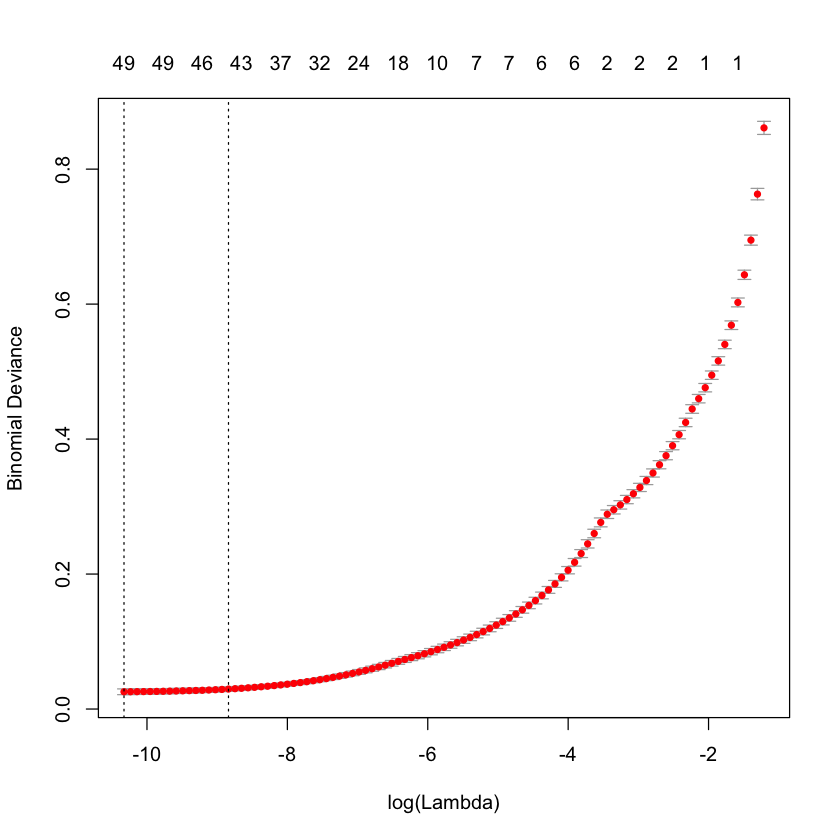

In [31]:
# Cross Validation
log.cv = cv.glmnet(x[1:10000, ], y[1:10000], family="binomial", alpha=1)
plot(log.cv)

In [38]:
log.cv$lambda.min
log.cv$lambda.1se

[1] 3.272704e-05

[1] 0.0001450011

In [44]:
# fit the logistic model with Lasso
log.model = glmnet(x, y, family="binomial", alpha=1, lambda=log.cv$lambda.1se)

In [51]:
# calculate log-loss
y.hat = predict(log.model, s=log.cv$lambda.1se, newx=x, type="response")
y = data$loan_status
loss = -sum(y * log(y.hat)) / length(y)
loss

[1] 0.06848935

# Random Forest

# GBM

# XGBoost

In [50]:
?predict.glmnet